In [1]:
# https://github.com/ipython/ipykernel/issues/111
# Create logger
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
import sys # create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)-15s : %(levelname)s : %(message)s') # - %(name)s %(clientip)s %(user)-8s
handler.setFormatter(formatter) # create formatter and add it to the handler
logger.handlers = [handler] # set STDERR handler as the only handler
logging.info('begin')

2017-04-19 14:41:14,282 : INFO : begin


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from importlib import reload
%matplotlib inline
np.random.seed(0)
tf.set_random_seed(0)

## CorpusStemmer analysis

#### Instructions for fitting this model:
1. Set `use_dep_model=False` in `TestCorpusStemmer._test_it` in test_corpus_stemmer.py.
2. Run the "test" (it's not really a test because it starts with an '_'): `nosetests test_corpus_stemmer:TestCorpusStemmer._test_it`.
3. Note that deputize.csv (in the repository) has been modified.  It shouldn't be off by much though.  The stdev and skew calculations may have changes to their least significant digits.  (corpus_stemmer_vocab.txt will also have been modified, but ignore that for now.)
4. Run this notebook.
5. Note that corpus_stemmer_model.pkl has been modified.
6. Confirm that the cross-validation in the last cell looks reasonable.
7. Set `use_dep_model` back to `True` in test_corpus_stemmer.py.
8. To test (or debug) the new model, set `prpfx` in corpus_stemmer.py to a valid prefix and run `TestCorpusStemmer._test_it` to view when the prefix gets deputized as a stem.
9. Another test is that the corpus_stemmer_vocab.txt file in tfae/datautils/resources did not change.
10. If desired, delete notebooks/20170307-SemanticSearch-count_words.pkl and corpus_stemmer.pkl which both depend on the stemmer.

In [3]:
import os
import pandas as pd
from tfae.datautils import corpus_stemmer

# this file is generated with the TestCorpusStemmer.test_it method
rsrcdir = os.path.join(os.path.dirname(corpus_stemmer.__file__), 'resources')
csv = pd.read_csv(os.path.join(rsrcdir, 'corpus_stemmer_deputize.csv'),
                  header=None, names=['nodepfx', 'amx', 'deputize', 'bdeputize',
                                      'nodecount', 'mag', 'numchildren', 'bhas_next_char', 'lennodepfx',
                                      'mx', 'sigcounts', 'sigalt', 'skewcounts', 'skewalt',
                                      'mxpct', 'sigpct', 'sigaltpct',
                                          'maxpct*mag',     # deputize 3
                                          'mx*maxpct',      # 4
                                          'nodecount*mag',  # 7
                                          'sigpct*mag',     # 8
                                          '(1-has_next_char)*st.maxpct'])  # 9

2017-04-19 14:41:15,420 : INFO : tf_autoencoder imported


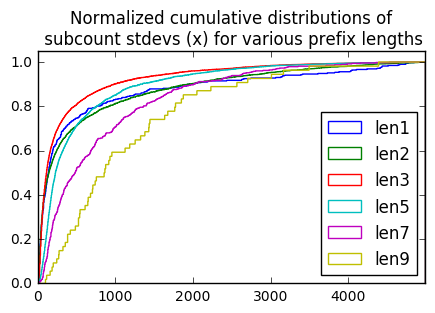

In [4]:
# Stdev distributions (normalized to all fit on the same chart)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for ilen, lpfx in enumerate([1, 2, 3, 5, 7, 9]):
    y = csv[csv.lennodepfx==lpfx].sigcounts#[csv.sigcounts>0]

    # This error will occur if the bin range is too small (e.g. 60):
    #     "UnboundLocalError: local variable 'ymin' referenced before assignment"
    # [https://github.com/matplotlib/matplotlib/issues/5221/]
    n, bins, patches = ax.hist(y, bins=[i*5+0.5 for i in range(1000)], normed=1,
                               histtype='step',
                               cumulative=True, label='len{}'.format(lpfx))

ax.set_xlim(0, bins[-2])
ax.set_ylim(0, 1.05)
ax.legend(loc='lower right')  # "subcount" == counts of each next letter following a prefix (after filtering)
ax.set_title('Normalized cumulative distributions of\n subcount stdevs (x) for various prefix lengths');
# https://en.wikipedia.org/wiki/Gamma_distribution

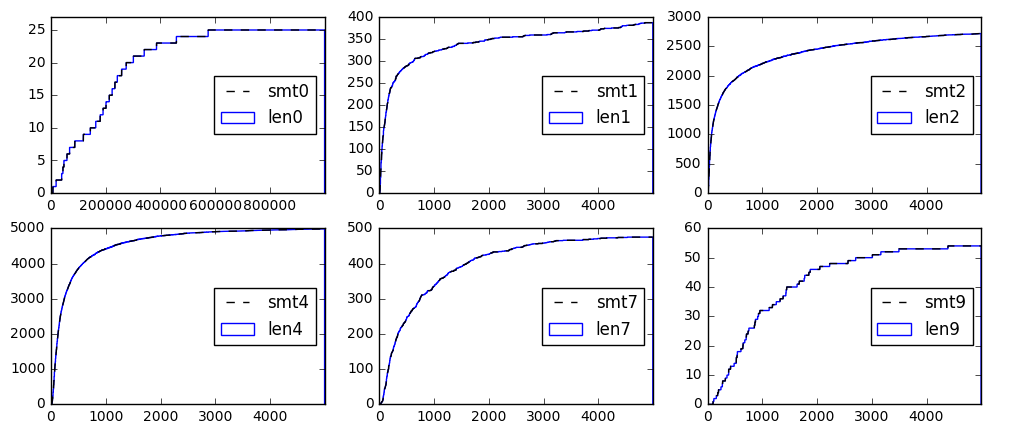

In [5]:
# Without normalization (i.e. different y scales; and including 0)
# The reason why 0 has so many is because the (26) 0th prefixes keep getting returned to
# over the course of the algorithm.  In the first iterations they have all 27 chars, but
# then slowly those chars get whittled away, along with the stdev's of their counts.
ncol = 3
fig, ax = plt.subplots(2, ncol, figsize=(12, 5))
for ilen, lpfx in enumerate([0, 1, 2, 4, 7, 9]):
    r = int(ilen / ncol)
    c = ilen % ncol
    
    y = csv[csv.lennodepfx==lpfx].sigcounts

    # This error will occur if the bin range is too small (e.g. 1000 for lpfx==0):
    #     "UnboundLocalError: local variable 'ymin' referenced before assignment"
    rg = 200000 if lpfx == 0 else 1000
    n, bins, patches = ax[r][c].hist(y, bins=[i*5+0.5 for i in range(rg)], #normed=1,
                               histtype='step',
                               cumulative=True, label='len{}'.format(lpfx))
    
    # http://matplotlib.org/examples/statistics/histogram_demo_cumulative.html
    #if lenprefix == 3:
    mids = [(a+b)/2 for a, b in zip(bins, bins[1:])]
    ax[r][c].plot(mids, n, 'k--', linewidth=1, label='smt{}'.format(lpfx))

    if lpfx == 0: ax[r][c].set_ylim(0, 27)
    ax[r][c].set_xlim(0, bins[-1])
    ax[r][c].legend(loc='right');

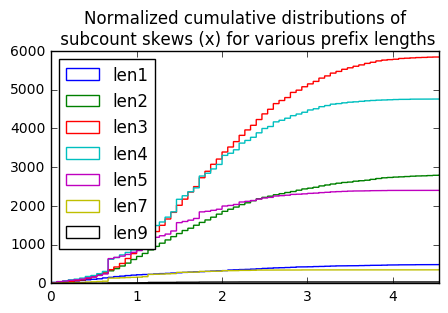

In [6]:
# Skew distributions (without normalization)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for ilen, lpfx in enumerate([1, 2, 3, 4, 5, 7, 9]):
    y = csv[csv.lennodepfx==lpfx].skewcounts #[csv['skew']>0]

    n, bins, patches = ax.hist(y, bins=[i/15+0.001 for i in range(70)], #normed=1,
                               histtype='step',
                               cumulative=True, label='len{}'.format(lpfx))

ax.set_xlim(0, bins[-2])
#ax.set_ylim(0, 1.05)
ax.legend(loc='upper left')  # "subcount" == counts of each next letter following a prefix (after filtering)
ax.set_title('Normalized cumulative distributions of\n subcount skews (x) for various prefix lengths');

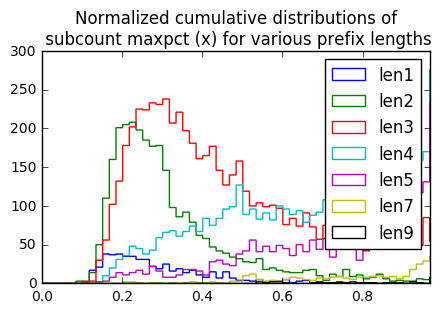

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for ilen, lpfx in enumerate([1, 2, 3, 4, 5, 7, 9]):
    y = csv[csv.lennodepfx==lpfx].mxpct #[csv['maxpct']>0]

    n, bins, patches = ax.hist(y, bins=[i/60+0.001 for i in range(60)], #normed=1,
                               histtype='step',
                               cumulative=False, label='len{}'.format(lpfx))

ax.set_xlim(0, bins[-2])
#ax.set_ylim(0, 1.05)
ax.legend(loc='best')  # "subcount" == counts of each next letter following a prefix (after filtering)
ax.set_title('Normalized cumulative distributions of\n subcount maxpct (x) for various prefix lengths');

***
## Logistic regression model to predict stems
* fit to statistics of (slightly preprocessed) word prefixes to determine which should be stems and which should not

In [8]:
print(csv.shape)
print(csv[csv.bdeputize==1].shape)
csv[csv.bdeputize==1][:500:50]

(20000, 22)
(3904, 22)


,nodepfx,amx,deputize,bdeputize,nodecount,mag,numchildren,bhas_next_char,lennodepfx,mx,...,skewcounts,skewalt,mxpct,sigpct,sigaltpct,maxpct*mag,mx*maxpct,nodecount*mag,sigpct*mag,(1-has_next_char)*st.maxpct
113,nine,NaN,9,1,210568,14,7,0,4,209917,...,2.041207,3.328184,0.996908,0.348666,0.256682,13.956717,209268.012656,2947952,4.881329,0.996908
1701,becau,s,8,1,10332,1,1,1,5,10332,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,10332.000000,10332,0.000000,0.000000
2552,claim,NaN,9,1,6468,2,2,0,5,6390,...,0.000000,0.000000,0.987941,0.487941,0.487941,1.975881,6312.940631,12936,0.975881,0.987941
3175,nation,NaN,9,1,5015,9,8,0,6,4816,...,2.261754,2.468478,0.960319,0.315935,0.300446,8.642871,4624.896510,45135,2.843415,0.960319
3674,market,NaN,9,1,4184,11,9,0,6,4056,...,2.472792,2.843809,0.969407,0.303520,0.277866,10.663480,3931.915870,46024,3.338724,0.969407
4104,album,NaN,9,1,3678,8,6,0,5,3659,...,1.788823,2.267755,0.994834,0.370369,0.328768,7.958673,3640.098151,29424,2.962954,0.994834
4506,busine,s,8,1,3253,9,1,1,6,3253,...,0.000000,2.455669,1.000000,0.000000,0.280724,9.000000,3253.000000,29277,0.000000,0.000000
4960,distinc,t,8,1,2894,10,1,1,7,2894,...,0.000000,1.249917,1.000000,0.000000,0.162633,10.000000,2894.000000,28940,0.000000,0.000000
5346,empl,o,10,1,2610,8,4,1,4,2589,...,1.154551,1.306978,0.991954,0.428377,0.163103,7.935632,2568.168966,20880,3.427013,0.000000
5674,britai,n,8,1,2389,2,1,1,6,2389,...,0.000000,0.000000,1.000000,0.000000,0.498744,2.000000,2389.000000,4778,0.000000,0.000000


In [9]:
from scipy.stats import skew, kurtosis
first_xcol = 4
P = csv.ix[:, first_xcol-2:]  # include numerical `deputize` for simplicity even though its values are categorical

desc = csv.describe().transpose()
desc.drop('count', axis=1, inplace=True)
desc['skew'] = pd.Series(    skew(P, axis=0), index=desc.index)
desc['kurt'] = pd.Series(kurtosis(P, axis=0), index=desc.index)
desc

,mean,std,min,25%,50%,75%,max,skew,kurt
deputize,8.933000e-01,3.826989e+00,-100.000000,0.000000,0.000000,0.000000,1.000000e+02,-6.093965,400.391244
bdeputize,1.952000e-01,3.963645e-01,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.538017,0.365496
nodecount,1.305243e+04,2.488418e+05,252.000000,444.000000,951.000000,2859.250000,1.679408e+07,45.870562,2417.021065
mag,2.623551e+02,3.892871e+03,1.000000,13.000000,38.000000,100.000000,2.089230e+05,39.548932,1722.819250
numchildren,1.062795e+01,6.472266e+00,1.000000,5.000000,10.000000,16.000000,2.600000e+01,0.322046,-0.975821
bhas_next_char,8.399500e-01,3.666616e-01,0.000000,1.000000,1.000000,1.000000,1.000000e+00,-1.854345,1.438595
lennodepfx,3.783400e+00,1.428071e+00,0.000000,3.000000,4.000000,5.000000,1.100000e+01,0.598828,0.540079
mx,4.046255e+03,3.863907e+04,32.000000,247.000000,539.000000,1736.500000,2.434556e+06,33.879414,1515.508464
sigcounts,1.133032e+03,9.845973e+03,0.000000,67.316063,170.648437,547.761246,5.742996e+05,31.195042,1258.925233
sigalt,2.994984e+02,1.393145e+03,0.000000,30.005308,85.735422,240.149627,6.079294e+04,25.561702,846.691540


In [10]:
# normalize each x column by its stdev
if False:
    n_xcols = csv.shape[1] - first_xcol
    for i in range(n_xcols):
        icol = csv.columns[first_xcol + i]
        if icol != 'bhas_next_char':
            csv[icol] /= np.std(csv[icol])

In [11]:
# remove all pct columns, which could cause singularities when adding 2nd-order columns
if False:
    csv.drop(['mxpct', 'sigpct', 'sigaltpct'], axis=1, inplace=True)

# add all 2nd-order columns
if False:
    n_xcols = csv.shape[1] - first_xcol
    for i in range(n_xcols):
        for j in range(i, n_xcols):
            icol = csv.columns[first_xcol + i]
            jcol = csv.columns[first_xcol + j]
            newcol = icol + '*' + jcol
            
            # these two cause NaNs in the regression (others do also)
            if newcol not in ['nodecount*nodecount', 'nodecount*mx']:
                csv[newcol] = csv[icol] * csv[jcol]
        #break

In [12]:
# revert back to original columns (excluding the pct ones)
if False:
    for c in csv.columns[14:]:
        csv.drop(c, axis=1, inplace=True)

In [13]:
# playing around with fitting distributions to the data (as an alternative to using pctrank),
# one way to do this would be to just generate 1000 random distributions and regress the actual
# data against them all and pick the best fit and take that distribution's parameters (i'm
# sure i've done something like this before)
# http://stackoverflow.com/questions/20626994/how-to-calculate-the-inverse-of-the-normal-cumulative-distribution-function-in-p
from scipy.stats import norm, skewnorm
print(norm.ppf(0.75), norm.ppf(0.95), norm.ppf(0.99))

variable_name = 'skewcounts'  # 'skewcounts' is the most normal of the variables (closest estimates)
mu = np.mean(csv[variable_name])
sig = np.std(csv[variable_name])
sk = skew(csv[variable_name])
print('mu = {}, sig = {}, skew = {}'.format(mu, sig, sk))

diffs = []
sk_diffs = []
for pct in (0.1, 0.25, 0.5, 0.75, 0.9):
    ptile = np.percentile(csv[variable_name], pct*100)
    est = norm.ppf(pct, loc=mu, scale=sig)
    sk_est = skewnorm.ppf(pct, sk, loc=mu, scale=sig)
    diffs.append((est - ptile) / sig)
    sk_diffs.append((sk_est - ptile) / sig)
    print('% = {}, percentile = {:.4f}, estimate = {:.4f}, sk_est = {:.4f}, diff/sig = {:.3f}, sk_diff/sig = {:.3f}'.format(int(pct*100), ptile, est, sk_est, diffs[-1], sk_diffs[-1]))
print('mean(abs(diffs)) = {:.3f} (and sk_diffs = {:.3f})'.format(np.mean(np.abs(diffs)), np.mean(np.abs(sk_diffs))))    

0.674489750196 1.64485362695 2.32634787404
mu = 1.5183819833758923, sig = 0.9964081692635178, skew = 0.2841834332579888
% = 10, percentile = 0.0000, estimate = 0.2414, sk_est = 0.4901, diff/sig = 0.242, sk_diff/sig = 0.492
% = 25, percentile = 0.7589, estimate = 0.8463, sk_est = 1.0794, diff/sig = 0.088, sk_diff/sig = 0.322
% = 50, percentile = 1.4887, estimate = 1.5184, sk_est = 1.7349, diff/sig = 0.030, sk_diff/sig = 0.247
% = 75, percentile = 2.1849, estimate = 2.1904, sk_est = 2.3911, diff/sig = 0.006, sk_diff/sig = 0.207
% = 90, percentile = 2.8553, estimate = 2.7953, sk_est = 2.9824, diff/sig = -0.060, sk_diff/sig = 0.128
mean(abs(diffs)) = 0.085 (and sk_diffs = 0.279)


In [14]:
from tfae.pipeline.step import variablenamer
reload(variablenamer)
var_namer = variablenamer.VariableNamer(csv.columns[first_xcol:])

2017-04-19 14:41:17,868 : DEBUG : VariableNamer.names = Index(['nodecount', 'mag', 'numchildren', 'bhas_next_char', 'lennodepfx', 'mx',
       'sigcounts', 'sigalt', 'skewcounts', 'skewalt', 'mxpct', 'sigpct',
       'sigaltpct', 'maxpct*mag', 'mx*maxpct', 'nodecount*mag', 'sigpct*mag',
       '(1-has_next_char)*st.maxpct'],
      dtype='object')


In [15]:
# add logs of some columns (would want to do this before normalizing by stdevs)
from tfae.pipeline.step import pipestepi
from tfae.pipeline.step import appendlogvariables
reload(pipestepi)
reload(appendlogvariables)
    
append_log_vars = None
if True:
    # some columns can go negative, these are the ones that don't (and aren't percentages)
    vars_to_log = ['nodecount', 'mag', 'numchildren', 'lennodepfx', 'mx', 'sigcounts', 'sigalt',
                   'maxpct*mag', 'mx*maxpct', 'nodecount*mag', 'sigpct*mag', '(1-has_next_char)*st.maxpct']
    append_log_vars = appendlogvariables.AppendLogVariables(vars_to_log)

2017-04-19 14:41:17,959 : DEBUG : AppendLogVariables: vars_to_log = ['nodecount', 'mag', 'numchildren', 'lennodepfx', 'mx', 'sigcounts', 'sigalt', 'maxpct*mag', 'mx*maxpct', 'nodecount*mag', 'sigpct*mag', '(1-has_next_char)*st.maxpct']


In [16]:
# Percent Rank
from tfae.pipeline.step import pipestepi
from tfae.pipeline.step import percentrank
from tfae.pipeline import pickles
reload(percentrank)
reload(pipestepi)
reload(pickles)

pct_rank_step = None
if True:
    # don't want to try to percentrank binary columns
    filter_vars = ['bhas_next_char']
    
    # PicklingError: Can't pickle <function <lambda> at 0x7f31049a2378>: it's not found as __main__.<lambda>
    #vfp = lambda v: v in filter_vars
    #def vfp(v): return v in filter_vars
    # vfp = pickles.incontainer(filter_vars)  # function returning function doesn't work either: PicklingError: Can't pickle <function incontainer.<locals>.f at 0x7f31045c67b8>: it's not found as tf_autoencoder.pipeline.pickles.incontainer.<locals>.f
    vfp = pickles.InContainer(filter_vars)
    vfp = pickles.InContainerOrStartsWith(filter_vars, 'log(')
    
    pct_rank_step = percentrank.PercentRank(var_filter_pred=vfp)

2017-04-19 14:41:18,051 : DEBUG : PercentRank: self._var_filter_pred = <tfae.pipeline.pickles.InContainerOrStartsWith object at 0x7fca38d1af28> (_container=['bhas_next_char'], _startswith='log(')


In [17]:
# extract `X` and `y` from `csv` (this is where `X` and `y` are DEFINED)
y = csv.bdeputize
X = csv.ix[:, first_xcol:]

# 'nine' should be located at index 112 (the first value w/ bdeputize==1)
nine_row = csv[csv.nodepfx=='nine'].index[0]
print(csv.shape)
print('y[{}] = {}'.format(csv['nodepfx'][nine_row], y[nine_row]))
print(X.ix[nine_row, :])

(20000, 22)
y[nine] = 1
nodecount                      2.105680e+05
mag                            1.400000e+01
numchildren                    7.000000e+00
bhas_next_char                 0.000000e+00
lennodepfx                     4.000000e+00
mx                             2.099170e+05
sigcounts                      7.341797e+04
sigalt                         5.404908e+04
skewcounts                     2.041207e+00
skewalt                        3.328184e+00
mxpct                          9.969084e-01
sigpct                         3.486663e-01
sigaltpct                      2.566823e-01
maxpct*mag                     1.395672e+01
mx*maxpct                      2.092680e+05
nodecount*mag                  2.947952e+06
sigpct*mag                     4.881329e+00
(1-has_next_char)*st.maxpct    9.969084e-01
Name: 113, dtype: float64


In [18]:
from sklearn.linear_model import LogisticRegression  # TODO: mess w/ C (regularization parameter; https://randomforests.wordpress.com/2014/02/02/basics-of-k-fold-cross-validation-and-gridsearchcv-in-scikit-learn/)
from tfae.pipeline import fpipeline
reload(fpipeline)

# the `deputize` binary variable being fit here may be biased--we have no assurances that it's
# not--we do not expect the manifold to be differently biased at different points in input space
# however so this will "learn" the proper shape, and then we choose a decision boundary
# afterwards anyway based on how the model behaves at different points along that boundary which
# makes the earlier bias moot by effectively introducing its own somewhat corrective bias
lr = LogisticRegression(solver='lbfgs', C=1.0, class_weight='balanced')  # 'balanced' => sample from 0s and 1s equally
model = fpipeline.make_fpipeline(var_namer, append_log_vars, pct_rank_step, lr)
model.fit(X, y)

# persist the model [http://scikit-learn.org/stable/modules/model_persistence.html]
# how to persist a full pipeline: http://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
from sklearn.externals import joblib
joblib.dump(model, os.path.join(rsrcdir, 'corpus_stemmer_model.pkl'))

2017-04-19 14:41:18,238 : DEBUG : AppendLogVariables: self._ivars = [0, 1, 2, 4, 5, 6, 7, 13, 14, 15, 16, 17]


['/home/fred/code/tf_autoencoder/tfae/datautils/resources/corpus_stemmer_model.pkl']

In [19]:
print('LogReg model intercept = {}'.format(model.intercept_))
print('LogReg model coefs (n={}) = {}'.format(len(model.coef_.reshape(-1)), model.coef_))
print('Pipeline prediction[112] (target: [0,1]) = {}'.format(model.predict_proba(X.ix[112, :].reshape(1, -1))))
print('Pipeline prediction[111] (target: [1,0]) = {}'.format(model.predict_proba(X.ix[111, :].reshape(1, -1))))

# 'anarc' gets chosen at 'anar' by the hackey rules, so it doesn't appear in deputize.csv, though it
# gets chosen at 'anarc' by the deputize_model, presumably because 'anar' is too short (model goes from
# 0.13 to 0.72)
print('Prefix predictions:')
for select_pfx in ['ana', 'anar', 'anarc', 'anarch', 'sen', 'sent', 'senti', 'sentim',
                   'inte', 'integ', 'intege', 'prop', 'propo', 'propos']:
    try:
        #idx = csv[csv.nodepfx==select_pfx].index[0]  # get FIRST index of select_pfx
        idxes = csv[csv.nodepfx==select_pfx].index
        #p1 = model.predict_proba(X.ix[idxes, :].reshape(1, -1))[0][1]
        p1 = model.predict_proba(X.ix[idxes, :])[:, 1]#.reshape(1, -1))[0][1]
        print('  {} = {}'.format(select_pfx, p1))
    except (IndexError, ValueError) as _:
        print('  {} = <not_found>'.format(select_pfx, p1))

LogReg model intercept = [ 1.79494121]
LogReg model coefs (n=30) = [[-0.65524497 -2.20610647 -0.12967417  3.90353128 -0.63650547 -1.07581071
   1.59789545  3.69011339 -2.65177618 -4.53082603  9.70766519 -4.71637161
   1.87206287  1.61564081 -1.19907007 -2.84603366  6.64139022  2.90132595
   0.40172293 -2.8558049   1.08619984  1.55344618 -0.1943976  -0.10106607
   0.34737489 -0.64529293 -0.64199097 -0.51682861 -0.90313901  7.24194672]]
Pipeline prediction[112] (target: [0,1]) = [[  9.99992919e-01   7.08083935e-06]]
Pipeline prediction[111] (target: [1,0]) = [[  9.99999999e-01   5.18256272e-10]]
Prefix predictions:
  ana = [  2.07075223e-09   8.40121922e-09   1.60485403e-08   1.83186480e-08
   1.34421139e-07   3.72799690e-07   9.84914500e-07   2.00889621e-06
   9.10580462e-06   1.06180306e-05   1.72360443e-05   5.65161101e-05]
  anar = [ 0.13974892]
  anarc = [ 0.73489747]
  anarch = <not_found>
  sen = [  3.26469909e-08   7.30503961e-08   1.76234101e-07   9.79807660e-07
   3.26659579e-0

In [20]:
# Model Evaluation (http://scikit-learn.org/stable/modules/model_evaluation.html)
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, precision_score, recall_score

print('Score: {}'.format(model.score(X, y)))  # should be around 0.94985
print('Cross-validated scores: {}\n'.format(cross_val_score(model, X, y, cv=5)))
y_pred = model.predict(X)
print(np.sum(y_pred))
confusion = confusion_matrix(y, y_pred)
print('Confusion matrix ([[tn,fp],[fn,tp]]):\n {}\n'.format(confusion))  # [[14776 1340] [159 3725]] => 1340/5065=0.74 1s were incorrectly classified as 0s
print('Classification report:')  # precision should be around 0.8, recall around 0.94
print(classification_report(y, y_pred))
print('Matthew\'s correlation coef: {}'.format(matthews_corrcoef(y, y_pred)))

tn = confusion[0][0]
fp = confusion[0][1]
fn = confusion[1][0]
tp = confusion[1][1]
p = tp / (fp + tp)  # precision = precision_score(y, y_pred)
r = tp / (fn + tp)  # recall_score(y, y_pred)
#print(p, r, 2 * p * r / (p + r))

Score: 0.94865
Cross-validated scores: [ 0.94051487  0.9085      0.968       0.94225     0.90797699]

4741
Confusion matrix ([[tn,fp],[fn,tp]]):
 [[15164   932]
 [   95  3809]]

Classification report:
             precision    recall  f1-score   support

          0       0.99      0.94      0.97     16096
          1       0.80      0.98      0.88      3904

avg / total       0.96      0.95      0.95     20000

Matthew's correlation coef: 0.855355408524827


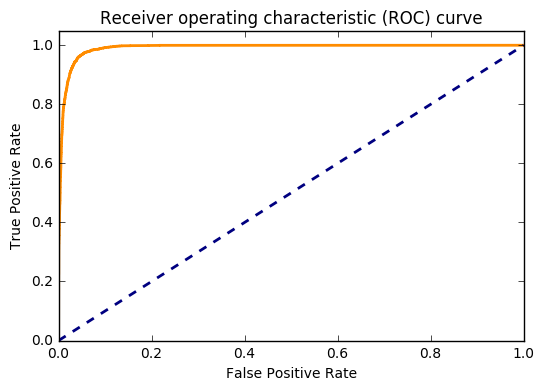

In [21]:
# ROC curve: "receiver operating characteristic (ROC) curve, is a graphical plot which illustrates
# the performance of a binary classifier system as its discrimination threshold is varied."
from sklearn.metrics import roc_curve
scores = model.predict_proba(X)[:, 1]  # "probability estimates of the positive class" [http://scikit-learn.org/stable/modules/model_evaluation.html]
fpr, tpr, thresholds = roc_curve(y, scores)

# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)#, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
#plt.legend(loc="lower right")
plt.show()


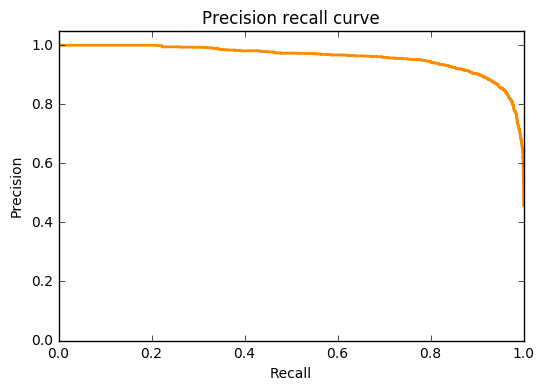

In [22]:
from sklearn.metrics import precision_recall_curve
ps, rs, thresholds2 = precision_recall_curve(y, scores)
plt.figure()
plt.plot(rs, ps, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision recall curve')
plt.show()

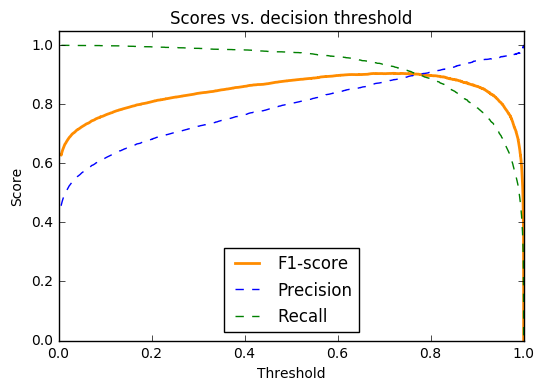

In [23]:
f1s = 2 * (ps * rs) / (ps + rs)
plt.figure()
plt.plot(thresholds2, f1s[:-1], color='darkorange', lw=2, label='F1-score')
plt.plot(thresholds2, ps[:-1], linestyle='--', label='Precision')
plt.plot(thresholds2, rs[:-1], linestyle='--', label='Recall')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Scores vs. decision threshold')
plt.legend(loc="lower center")
plt.show()

0.67925902472 780
0.709779914256 768
0.741204828435 757
0.765337740679 765
0.794345958215 791
0.818624555384 802
0.837980586643 844


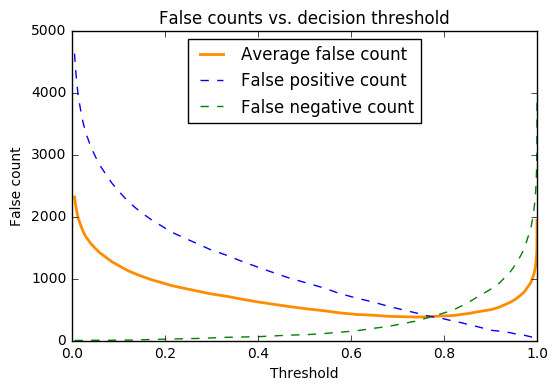

In [24]:
# compute false positive/negative counts for each threshold, since we don't really have an
# opinion on the bias in our ys, we should just choose a threshold where fp is about equal to fn
filt_threshs = []
fps = []
fns = []
for i, thresh in enumerate(thresholds2):
    if i % 100 == 0:
        filt_threshs.append(thresh)
        fps.append(np.sum((scores > thresh) & (y == 0)))
        fns.append(np.sum((scores < thresh) & (y == 1)))
        if (thresh > 0.65 and thresh < 0.85):  # min is around 0.76
            print(thresh, fps[-1] + fns[-1])
    
fps = np.array(fps)
fns = np.array(fns)
#avgs = 1/(2 * 1/fps * 1/fns / (1/fps + 1/fns))  # inverse of harmonic average of inverses is...
avgs = (fps + fns) / 2                                 # ...the same as the average

plt.figure()
plt.plot(filt_threshs, avgs, color='darkorange', lw=2, label='Average false count')
plt.plot(filt_threshs, fps, linestyle='--', label='False positive count')
plt.plot(filt_threshs, fns, linestyle='--', label='False negative count')
plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('False count')
plt.title('False counts vs. decision threshold')
plt.legend(loc="upper center")
plt.show()

In [25]:
# Stratified Cross Validation [http://scikit-learn.org/stable/modules/cross_validation.html]
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
split1 = StratifiedKFold(n_splits=3)
split2 = StratifiedShuffleSplit(n_splits=3)
for tr, te in split1.split(X, y):
    print('{} {}'.format(tr, te))
for tr, te in split2.split(X, y):
    print('{} {}'.format(tr, te))
print('\nStratifiedKFold, cross-validated scores: {}'.format(cross_val_score(model, X, y, cv=split1)))
print('StratifiedShuffleSplit, cross-validated scores: {}'.format(cross_val_score(model, X, y, cv=split2)))

[ 5844  5845  5846 ..., 19997 19998 19999] [   0    1    2 ..., 9609 9613 9622]
[    0     1     2 ..., 19997 19998 19999] [ 5844  5845  5846 ..., 15133 15137 15140]
[    0     1     2 ..., 15133 15137 15140] [12761 12764 12765 ..., 19997 19998 19999]
[14718 19925  6610 ...,  5484 11911 18179] [10725  7330 19523 ...,  3109  9486  3754]
[13234 14552 13370 ...,  5738 13372  3534] [ 9834  5954  2006 ..., 10968  9844 14006]
[11100    36 15214 ...,  2887  9189 17119] [  345 15586 11542 ..., 18675 11235 15921]

StratifiedKFold, cross-validated scores: [ 0.93836233  0.96249625  0.87053705]
StratifiedShuffleSplit, cross-validated scores: [ 0.937   0.9455  0.9535]


In [26]:
# Bootstrapped computation of standard errors (and t-stats)
# What follows isn't exactly right, but it's easier than what's described here:
# https://www.researchgate.net/post/How_to_compute_the_standard_errors_of_binary_logistic_regressions_coefficients
coefs = []
n_splits = 32
split3 = StratifiedShuffleSplit(n_splits=n_splits)
for tr, te in split3.split(X, y):
    #print(model.fit(X.ix[tr], y[tr]).score(X.ix[te],y[te]))
    model.fit(X.ix[tr], y[tr])
    
    # if you forget to put the values to np.concatenate inside a tuple, you receive the
    # following error: "TypeError: only length-1 arrays can be converted to Python scalars"
    coefs.append(np.concatenate((model.intercept_, model.coef_.reshape(-1))))

# recompute the original model for the original model coefficients
model.fit(X, y)
cf = np.concatenate((model.intercept_, model.coef_.reshape(-1)))

coefs = np.array(coefs)  # coefficients from the `n_splits` trials
mu = np.mean(coefs, axis=0)
sig = np.std(coefs, axis=0)
sk = skew(coefs, axis=0)
#t = z * np.sqrt(n_splits)
p25 = np.percentile(coefs, 25, axis=0)  # perhaps better to use R8 method for median/quantiles/percentiles
med = np.median(coefs, axis=0)          # described here: https://stat.ethz.ch/R-manual/R-devel/library/stats/html/quantile.html
p75 = np.percentile(coefs, 75, axis=0)
z = med / sig

# this is a metric of how close the 3 coefficient estimates are to each other
# median(abs(coef)) / (max(coef) - min(coef))
three_coef_ests = np.concatenate((cf.reshape(-1, 1), mu.reshape(-1, 1), med.reshape(-1, 1)), axis=1)
mx = np.max(three_coef_ests, axis=1)
mn = np.min(three_coef_ests, axis=1)
rdiff = np.median(np.abs(three_coef_ests), axis=1) / (mx - mn)

# variable medians (as opposed to bootstrapped medians of coefficients)
varmed = np.concatenate((np.ones(1), np.median(X, axis=0)))
#print(varmed * med)  # similar to E[fcast] i suppose (before being fed through logistic)
#print(1 / (1 + np.exp(-varmed * med)))

# TODO: put this data into a dataframe and just 'describe' that!!!!

x_names = ['intercept'] + model.variable_names #list(csv)[first_xcol:]  # append column names to 'intercept'
header = ' '.join('{:>8s}'.format(c) for c in 'Z RDiff 25th Median Coef Mu 75th Std Skew'.split())
print('{:>35s} = {}'.format('Variable', header))
for tup in zip(x_names, z, rdiff, p25, med, cf, mu, p75, sig, sk):
    vals = ' '.join('{:8.3f}'.format(v) for v in tup[1:])
    print('{:>35s} = {}'.format(tup[0], vals))

                           Variable =        Z    RDiff     25th   Median     Coef       Mu     75th      Std     Skew
                          intercept =   10.485    7.137    1.933    2.047    1.795    2.082    2.202    0.195    0.132
                       r(nodecount) =   -1.812    1.988   -0.607   -0.504   -0.655   -0.402   -0.235    0.278    0.754
                             r(mag) =  -10.014    6.386   -2.023   -1.919   -2.206   -1.906   -1.825    0.192    0.225
                     r(numchildren) =   -1.240    2.424   -0.297   -0.176   -0.130   -0.202   -0.081    0.142   -0.422
                     bhas_next_char =    5.856    4.017    2.952    3.340    3.904    3.072    3.408    0.570   -1.358
                      r(lennodepfx) =   -2.060    5.702   -0.696   -0.531   -0.637   -0.603   -0.440    0.258   -1.028
                              r(mx) =   -2.171    2.094   -0.922   -0.849   -1.076   -0.670   -0.515    0.391    1.237
                       r(sigcounts) =    5.864  

In [27]:
logging.debug('end')

2017-04-19 14:41:30,587 : DEBUG : end
